In [4]:
import glob

import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn as nn
import onnxruntime as ort
import time
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage


sys.path.append("/scratch/csonnabe/cern-fellowship/classes")

from Custom.customFunctions import *
from GeneralPurposeClass.extract_from_root import *
from NeuralNetworkClass.NeuralNetworkClasses.NN_class import *
from NeuralNetworkClass.NeuralNetworkClasses.utils.dataset_loading import *

import itertools
from hashlib import sha1

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from scipy.optimize import curve_fit

import mplhep as hep
plt.style.use(hep.styles.ALICE)
for key in mpl.rcParams.keys():
    if key.startswith('legend.'):
        mpl.rcParams[key] = mpl.rcParamsDefault[key]

globalPath = machinePaths()

def network(data, ort_session):
    return np.array(ort_session.run(None, {'input': (torch.tensor(data).float()).numpy()}))

max_rows_idx = np.loadtxt(globalPath["path"] + "/PhD/jobs/clusterization/NN/src/O2_TABLES/TPC/PAD_ROW_MAX.txt",dtype=str)

In [5]:
cload = load_tree(20)

# Raw

In [21]:
# data import

df = pd.read_csv("/lustre/alice/users/csonnab/PhD/jobs/clusterization/QA/output/24012026_PbPb_aMC_24arp2_559843_newTracking_clusterError/gpu_cf/reco/dump_cluster_error.csv")  # add sep=',' if needed

/u/csonnab/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
df = df.iloc[:-1]
df = df.astype(np.float32)

In [ ]:
counts = df["cluster.num"].value_counts().sort_index()
counts.plot(kind="bar")
plt.xlabel("cluster.num")
plt.ylabel("count")
plt.tight_layout()
plt.show()

In [ ]:
df_filtered = df[df["cluster.num"].map(df["cluster.num"].value_counts()) > n]

In [ ]:
data = df_filtered.to_numpy()

In [ ]:
latest_clusters = df_filtered.groupby("cluster.num", sort=False).tail(1)

In [ ]:
latest_clusters.to_csv("/lustre/alice/users/csonnab/PhD/jobs/clusterization/QA/output/24012026_PbPb_aMC_24arp2_559843_newTracking_clusterError/gpu_cf/tmp/latest_clusters.csv", index=False)

# Processed

In [3]:
test = pd.read_csv("/lustre/alice/users/csonnab/PhD/jobs/clusterization/QA/output/24012026_PbPb_aMC_24arp2_559843_newTracking_clusterError/gpu_cf/reco/latest_clusters.csv")

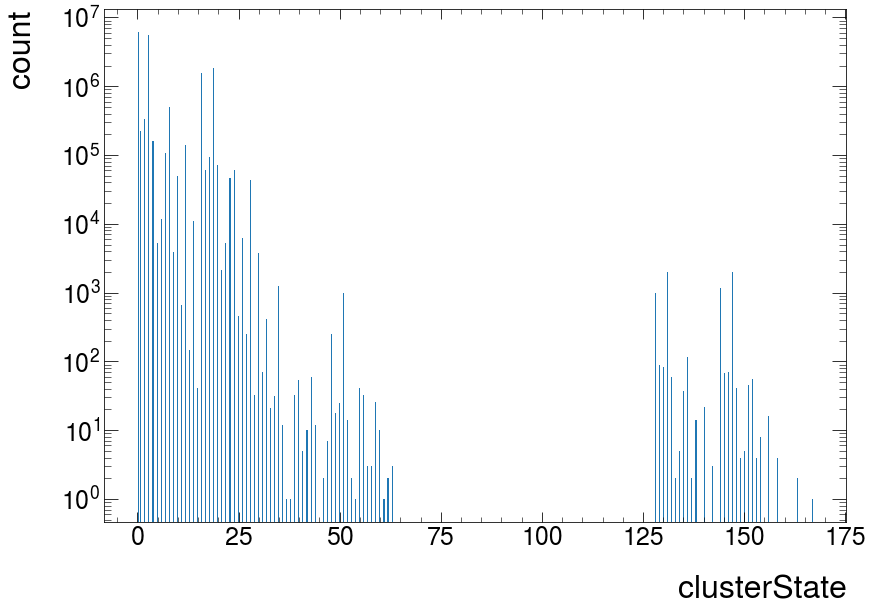

In [4]:
clusterStates = test["clusterState"].to_numpy()
plt.hist(clusterStates, align='mid', rwidth=0.8, bins=500)
plt.xlabel("clusterState")
plt.ylabel("count")
plt.tight_layout()
plt.yscale("log")
plt.show()


In [5]:
for l in test.columns:
    print(l,"\t", np.min(test[l]), "\t", np.max(test[l]))

internal_trkid 	 0.0 	 460081.0
cluster.num 	 56.0 	 35336588.0
err2Y 	 0.003604 	 186.0446
err2Z 	 0.003679 	 472.49237
clusterState 	 0.0 	 167.0
xx 	 83.63141999999999 	 248.2709
yy 	 -41.66666 	 43.579334
zz 	 -397.46585 	 424.75793
mP[0] 	 -377.71716000000004 	 365.58807
mP[1] 	 -397.33337 	 397.6382
mP[2] 	 -9.469648 	 12.753639999999999
mP[3] 	 -29.668084999999998 	 48.997925
mP[4] 	 -478.3892 	 336.4162
mC[0] 	 0.00037400000000000004 	 37462496.0
mC[2] 	 0.000315 	 4011799.5
mC[5] 	 0.0 	 587.0327
mC[9] 	 0.0 	 10.271796
mC[14] 	 3.6e-05 	 290.81717000000003


In [38]:
mask = (np.log10(test["mC[0]"]) < 0) & (np.log10(test["mC[2]"]) < 0) & (np.abs(test["mP[0]"] - test["yy"]) < 5) & (np.abs(test["mP[1]"] - test["zz"]) < 5)

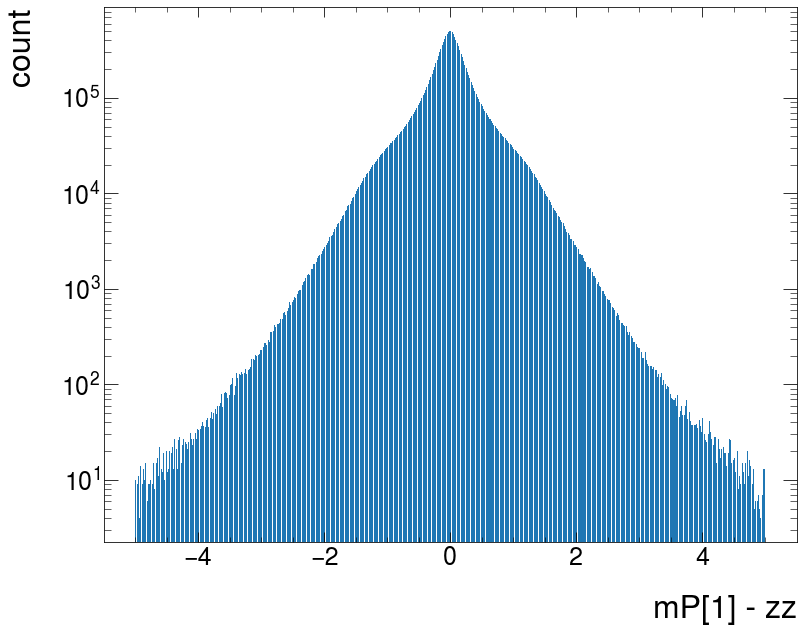

In [39]:
tt = (test["mP[1]"] - test["zz"]).to_numpy()[mask]
plt.hist(tt, align='mid', rwidth=0.8, bins=500)
plt.xlabel("mP[1] - zz")
plt.ylabel("count")
plt.tight_layout()
plt.yscale("log")
# plt.xscale("log")
plt.show()


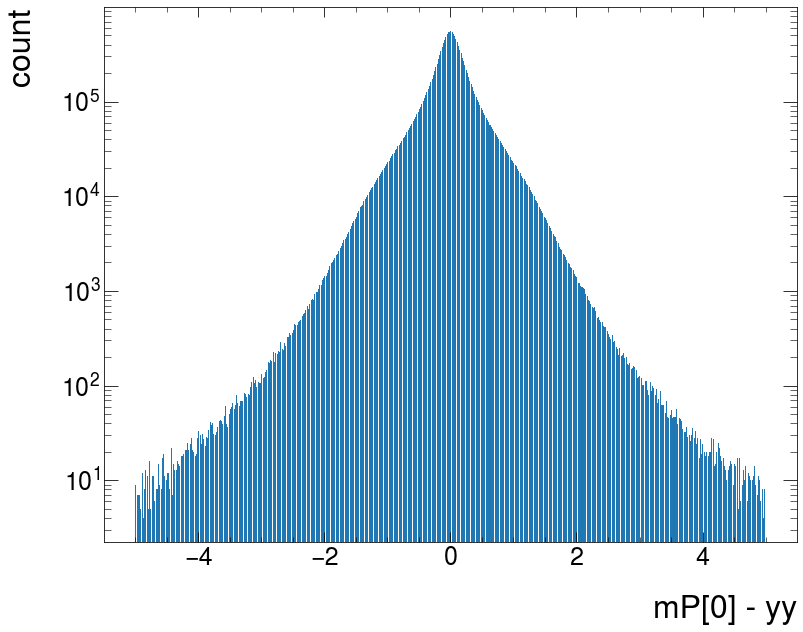

In [40]:
tt = (test["mP[0]"] - test["yy"]).to_numpy()[mask]
plt.hist(tt, align='mid', rwidth=0.8, bins=500)
plt.xlabel("mP[0] - yy")
plt.ylabel("count")
plt.tight_layout()
plt.yscale("log")
# plt.xscale("log")
plt.show()


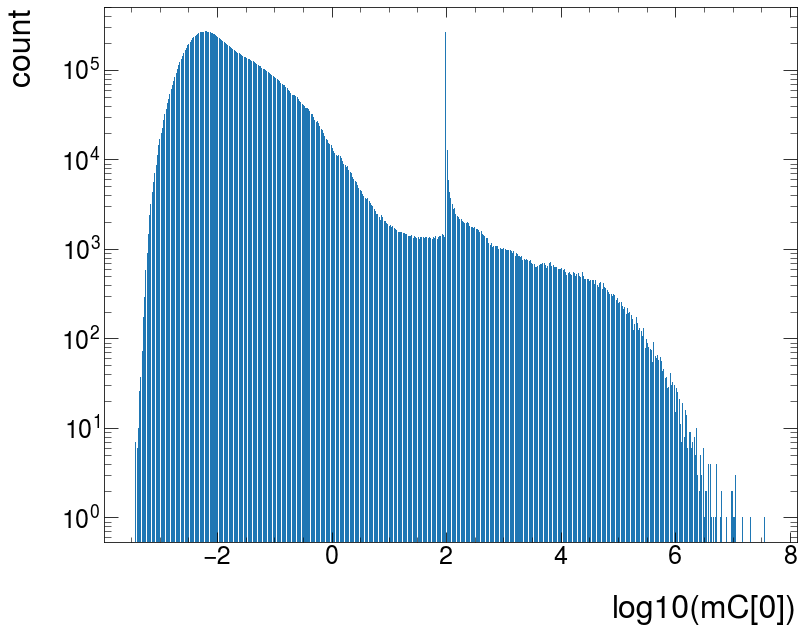

In [12]:
tt = np.log10(test["mC[0]"].to_numpy())
plt.hist(tt, align='mid', rwidth=0.8, bins=500)
plt.xlabel("log10(mC[0])")
plt.ylabel("count")
plt.tight_layout()
plt.yscale("log")
# plt.xscale("log")
plt.show()


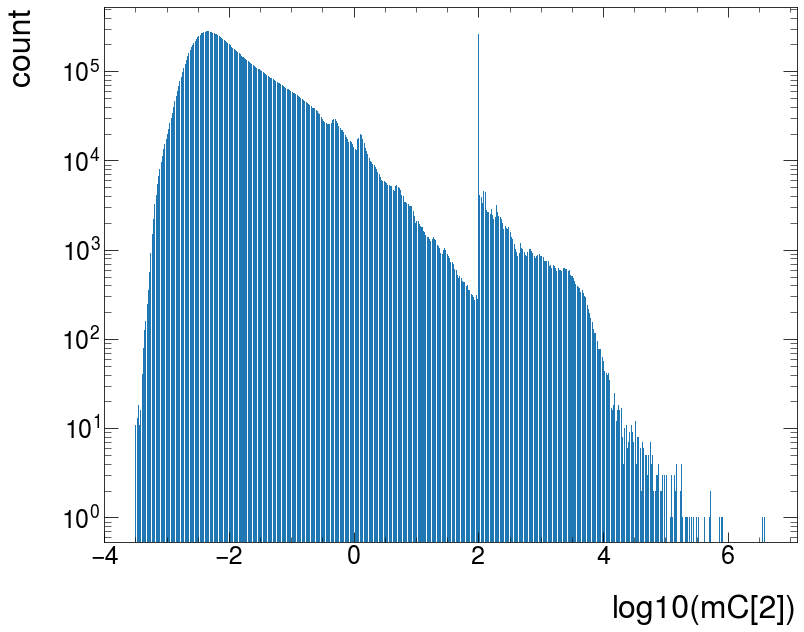

In [13]:
tt = np.log10(test["mC[2]"].to_numpy())
plt.hist(tt, align='mid', rwidth=0.8, bins=500)
plt.xlabel("log10(mC[2])")
plt.ylabel("count")
plt.tight_layout()
plt.yscale("log")
# plt.xscale("log")
plt.show()


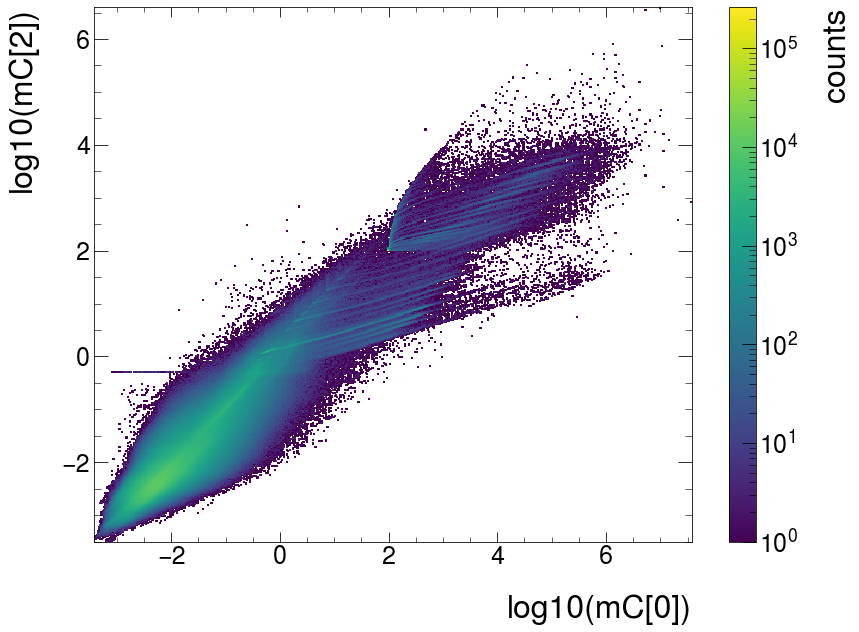

In [17]:
plt.hist2d(np.log10(test["mC[0]"].to_numpy()), np.log10(test["mC[2]"].to_numpy()), bins=500, norm = colors.LogNorm())
plt.xlabel("log10(mC[0])")
plt.ylabel("log10(mC[2])")
plt.tight_layout()
plt.colorbar(label="counts")
plt.show()

# Output

In [6]:
input_data = pd.read_csv("/scratch/csonnabe/PhD/jobs/clusterization/NN/data/output/08022026_clusterErrorParameterization/latest_clusters.csv")

In [7]:
nn_dir = "/scratch/csonnabe/cern-fellowship/run/jobs/clusterization/NN/output/15022026_clusterErrorParameterization"

# load_network = glob.glob(os.path.join(nn_dir, "**/net.onnx"), recursive=True)[0]
load_network = glob.glob(os.path.join(nn_dir, "**/net.onnx"), recursive=True)[0]
load_config = glob.glob(os.path.join(nn_dir, "**/configurations.py"), recursive=True)[0]

In [8]:
data_transformer = load_attr_from_file(load_config, "data_transformer")
labels_x = load_attr_from_file(load_config, "labels_x")
labels_y = load_attr_from_file(load_config, "labels_y")

In [9]:
X, Y = data_transformer(input_data[labels_x], input_data[labels_y], step=1)

In [10]:
np.shape(X)

(16457426, 19)

In [11]:
X[:10]

array([[ 9.5350304e+01,  5.2144752e+00,  5.3783661e+01,  7.5000000e-01,
         3.7500000e-01,  5.2914310e+00,  5.1854736e+01, -3.3293000e-01,
         5.3056401e-01,  1.0028221e+01,  2.7450600e-01,  3.6323699e-01,
         1.0564600e-01,  1.8619999e-01,  1.0028336e+01,  0.0000000e+00,
         1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 9.4480858e+01,  5.1994300e+00,  5.3586975e+01,  7.1875000e-01,
         5.9375000e-01,  5.4757490e+00,  5.3692497e+01, -2.7887699e-01,
        -4.1836801e-01,  1.0032624e+01,  4.3435000e-02,  2.5238699e-01,
         2.5460999e-02,  6.9798000e-02,  1.0026655e+01,  1.0000000e+00,
         1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 8.7627487e+01,  7.9991560e+00,  5.7280823e+01,  0.0000000e+00,
         5.0000000e-01,  7.2866750e+00,  5.6498505e+01, -2.0264500e-01,
        -4.0321901e-01,  9.8411427e+00,  9.7976997e-02,  1.0758100e-01,
         2.0989999e-03,  2.2780001e-03,  9.8930779e+00,  0.0000000e+00,
         0.0000000e+00

In [12]:
sess_options = ort.SessionOptions()
sess_options.intra_op_num_threads = 20  # Set the number of threads for intra-op parallelism
sess_options.inter_op_num_threads = 20  # Set the number of threads for inter-op parallelism

providers = ['CPUExecutionProvider']

ort_sess = ort.InferenceSession(load_network, sess_options, providers=providers)

In [13]:
net_output = network(X, ort_session=ort_sess)[0]

In [14]:
newX = input_data[labels_x].copy()
if "clusterState" in newX.columns:
    s = newX["clusterState"].to_numpy(dtype=np.uint8)
    newX["cs0"] = ((s >> 0) & 1).astype(np.float32)
    newX["cs1"] = ((s >> 1) & 1).astype(np.float32)
    newX["cs2"] = ((s >> 2) & 1).astype(np.float32)
    newX["cs3"] = ((s >> 3) & 1).astype(np.float32)
    newX = newX.drop(columns=["clusterState"])
newX = newX.to_numpy()
net_output = network(newX, ort_session=ort_sess)[0]

In [15]:
mask = (input_data["mC[0]"] < 0.1) & (input_data["mC[2]"] < 0.1) & np.isfinite(input_data["mC[0]"]) & np.isfinite(input_data["mC[2]"])

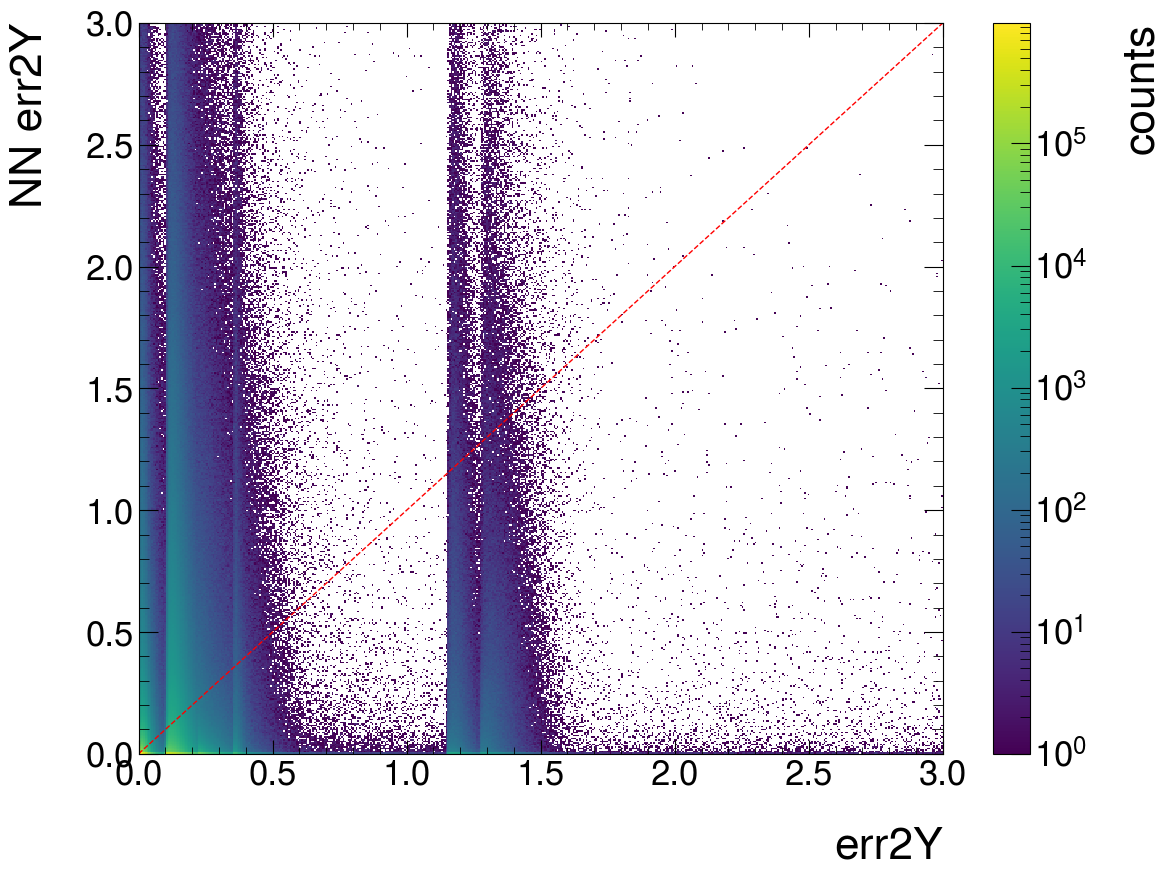

In [16]:
plt.hist2d(input_data[mask]["err2Y"], net_output[mask,0], bins=500, norm = colors.LogNorm(), range=[[0, 3], [0, 3]])
plt.plot([0, 10], [0, 10], color="red", linestyle="--")
plt.xlabel("err2Y")
plt.ylabel("NN err2Y")
plt.tight_layout()
plt.colorbar(label="counts")
plt.show()

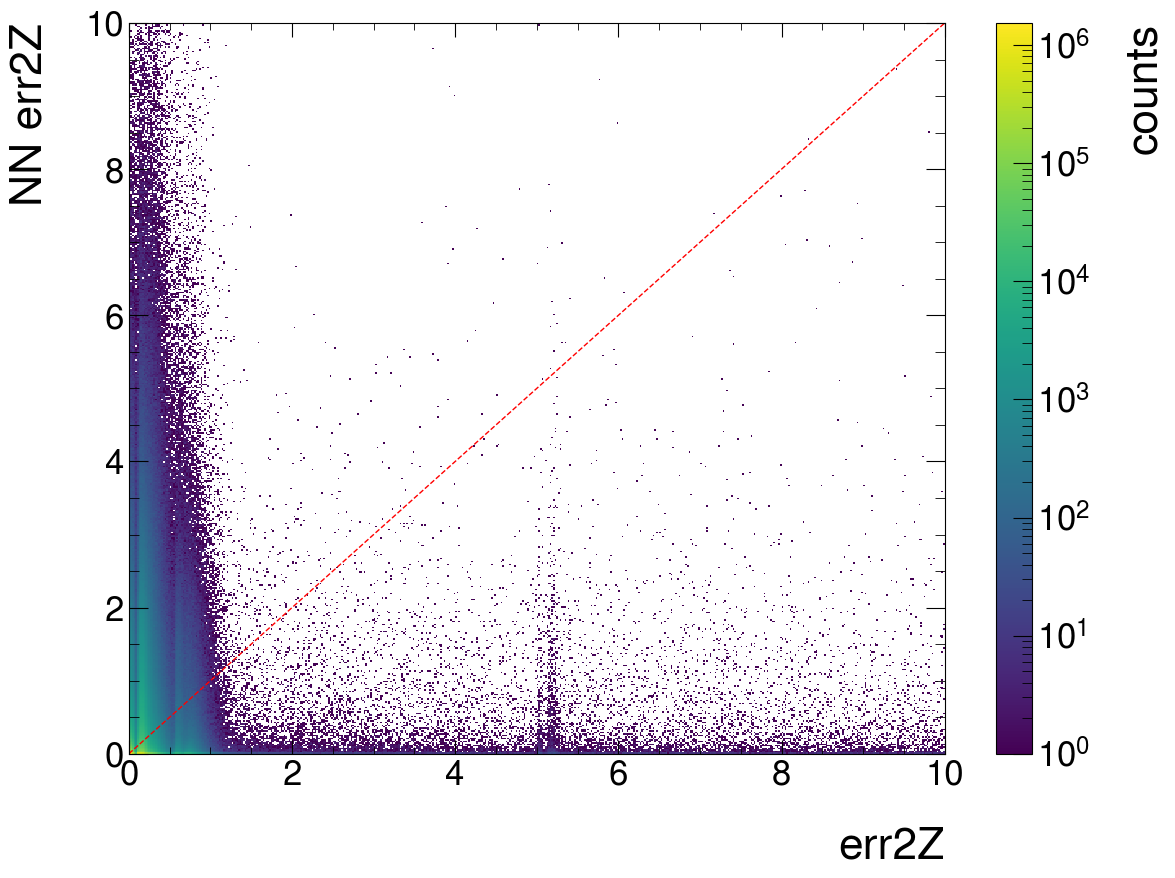

In [17]:
plt.hist2d(input_data[mask]["err2Z"], net_output[mask,1], bins=500, norm = colors.LogNorm(), range=[[0, 10], [0, 10]])
plt.plot([0, 10], [0, 10], color="red", linestyle="--")
plt.xlabel("err2Z")
plt.ylabel("NN err2Z")
plt.tight_layout()
plt.colorbar(label="counts")
plt.show()

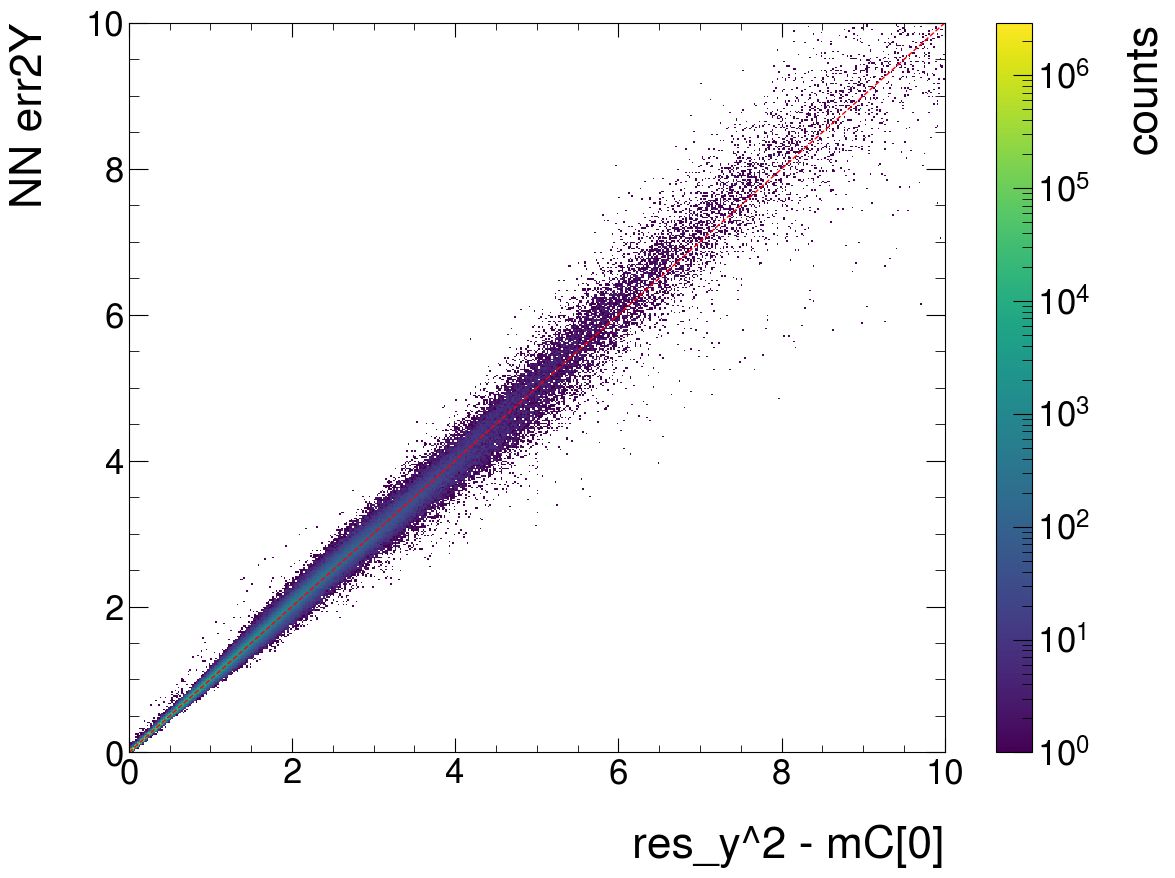

In [18]:
plt.hist2d(((input_data["yy"] - input_data["mP[0]"])**2 - input_data["mC[0]"])[mask], net_output[mask,0], bins=500, norm = colors.LogNorm(), range=[[0, 10], [0, 10]])
plt.plot([0, 10], [0, 10], color="red", linestyle="--")
plt.xlabel("res_y^2 - mC[0]")
plt.ylabel("NN err2Y")
plt.tight_layout()
plt.colorbar(label="counts")
plt.show()

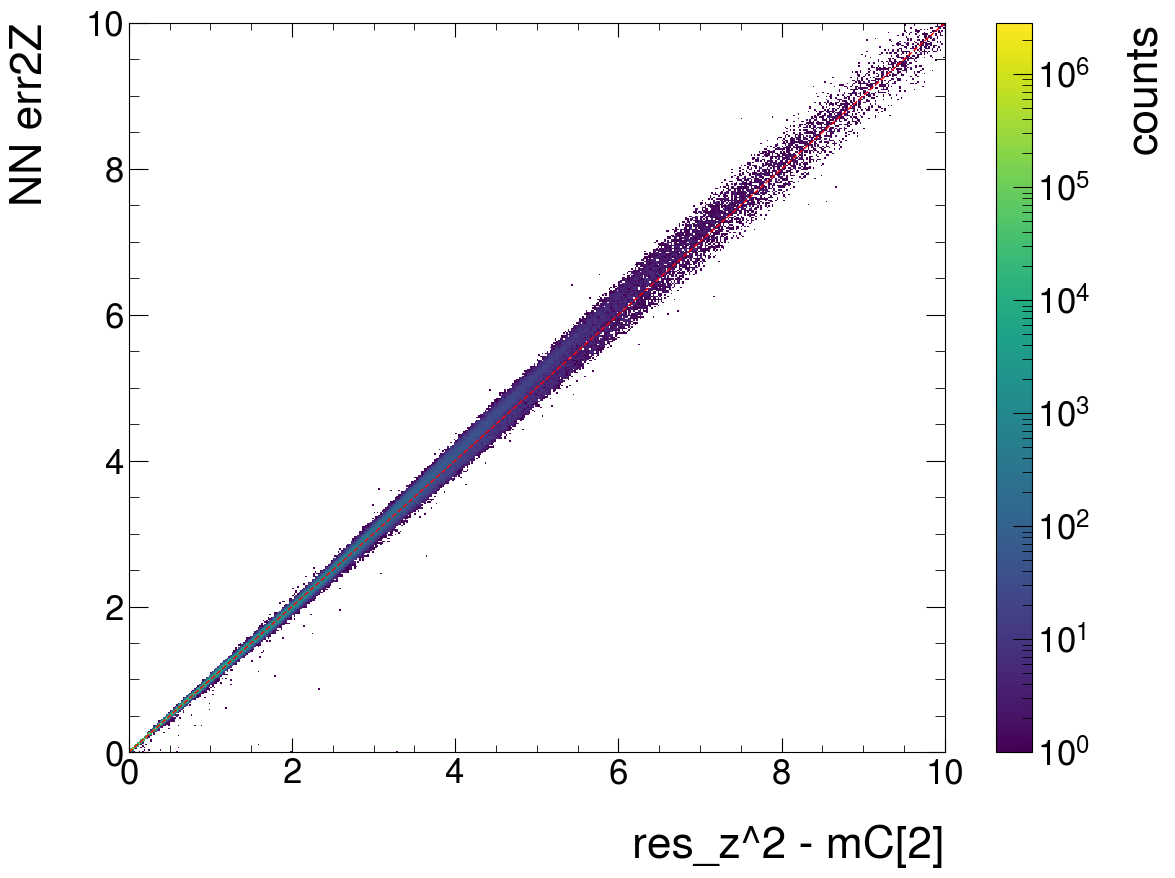

In [19]:
plt.hist2d(((input_data["zz"] - input_data["mP[1]"])**2 - input_data["mC[2]"])[mask], net_output[mask,1], bins=500, norm = colors.LogNorm(), range=[[0, 10], [0, 10]])
plt.plot([0, 10], [0, 10], color="red", linestyle="--")
plt.xlabel("res_z^2 - mC[2]")
plt.ylabel("NN err2Z")
plt.tight_layout()
plt.colorbar(label="counts")
plt.show()

In [20]:
loss = load_attr_from_file(load_config, "NLLloss")

In [21]:
idx__yy = labels_x.index("yy")
idx__zz = labels_x.index("zz")
idx__mP0 = labels_x.index("mP[0]")
idx__mP1 = labels_x.index("mP[1]")
idx__mC0 = labels_x.index("mC[0]")
idx__mC2 = labels_x.index("mC[2]")


loss(torch.tensor(np.vstack([(X[:,idx__yy] - X[:,idx__mP0])**2 - X[:,idx__mC0], (X[:,idx__zz] - X[:,idx__mP1])**2 - X[:,idx__mC2]]).T), torch.tensor(Y))

tensor(11916.7402)